# Overview

- Amazon SageMaker를 사용하는 방법에 대한 실습
- ML 모델 구축, 교육 및 배포
- 알고리즘: XGBoost ML Algorithm 사용
- Amazon SageMaker는 개발자와 데이터 과학자(Data Scientist)가 ML 모델을 대규모로 구축, 교육 및 배포할 수 있도록 하는 모듈식 완전 관리형 기계 학습 서비스

- 이번 실습에서는 '은행에서 일하는 ML 개발자의 역할'
- 고객이 예금 증명서(CD)에 등록할 지 여부를 예측하기 위해 ML 모델을 개발하라는 요청을 받음
- 모델은 고객 인구 통계, 마케팅 이벤트에 대한 응답 및 외부 요인에 대한 정보가 포함된 마케팅 데이터 세트에 대해 학습 진행
- 사용자 편의를 위해 데이터에 Label이 지정되었으며, 데이터 세트의 열은 고객이 은행에서 제공하는 제품에 등록되었는지 여부를 식별
- 이 데이터 세트의 버전은 공개적으로 사용 가능
- 이 튜토리얼은 데이터에 Label이 지정되어 있기 때문에 Supervised Machine Learning 모델을 구현

## Feature Engineering

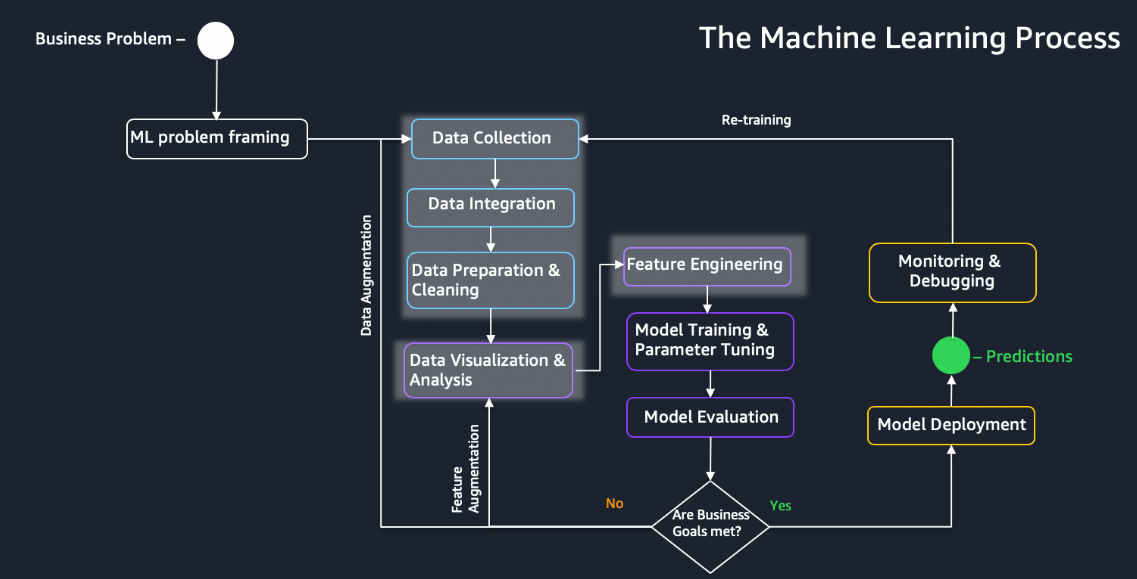

### Amazon SageMaker Processing
- Input: Amazon S3
- Output: Amazon S3
- Amazon SageMaker Processing을 사용하려면 Python Data Preprocessing Script를 이용
- 데이터 Preprocessing을 위해 SageMaker에서 사전에 Build된 Scikit-learn container 사용
- input, output data는 지정된 경로에 배치되어야 함
    - **/opt/ml/processing/input/ - 입력 데이터용**
    - **/opt/ml/processing/output/ - 출력 데이터용**

![processing](https://sagemaker.readthedocs.io/en/stable/_images/amazon_sagemaker_processing_image1.png)

이 실습에서는 데이터 세트를 가져와서 SageMaker Processing으로 변환
- SageMaker Processing은 Notebook instance를 실행하는 것과 별도의 SageMaker 관리 Cluster에서 데이터를 처리하는 데 사용할 수 있음
- 일반적인 SageMaker Workflow에서는 Notebook instance는 Prototype 제작에만 사용되며, 상대적으로 저렴하고 덜 강력한 인스턴스에서 실행
- Preprocessing, Model Training and Hosting은 별도의 더 강력한 SageMaker 관리 Instance에서 실행

### Targeting Direct Marketing with Amazon SageMaker XGBoost

**Supervised Learning with Gradient Boosted Trees: A Binary Prediction Problem With Unbalanced Classes**


---

Background
- 우편, 이메일, 전화 등을 통한 직접 마케팅은 고객을 획득하기 위한 일반적인 전술
- 리소스와 고객의 관심이 제한적이기 때문에 목표는 특정 오퍼에 참여할 가능성이 있는 잠재 고객의 하위 집함만을 대상으로 진행
- 인구 통계, 과거 상호 작용 및 환경 요인과 같은 쉽게 이용할 수 있는 정보를 기반으로 이러한 잠재적 고객을 예측하는 것이 ML 문제

Steps
- Amazon SageMaker Notebook Instance 준비
- 인터넷에서 Amazon SageMaker로 데이터 다운로드
- Amazon SageMaker 알고리즘에 데이터를 제공할 수 있도록 데이터 조사 및 변환
- Gradient Boosting 알고리즘을 사용한 모델 추정
- 모델의 성능 평가
- 지속적인 예측을 하기 위한 모델 설정

1. Preparation
- train 및 Model 데이터에 사용할 S3 Bucket 및 Prefix는 Notebook Instance와 동일한 region 내에 있어야 함

In [4]:
import sagemaker


bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/DEMO-xgboost-dm'

print("Sagemaker Default Path: ", bucket + '/' + prefix)

Sagemaker Default Path:  sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm


In [7]:
# Define IAM Role
import boto3
import re


role = sagemaker.get_execution_role()
print("IAM Role: ", role)

IAM Role:  arn:aws:iam::988889742134:role/service-role/AmazonSageMaker-ExecutionRole-20220315T092490


In [9]:
# Environment variables
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
import sys
import math
import json
import os
import sagemaker
import zipfile

2. Data Download and Unzip

In [10]:
!wget https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip


--2022-04-27 05:27:48--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.218.176.89
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.218.176.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 422.68K   855KB/s    in 0.5s    

2022-04-27 05:27:49 (855 KB/s) - ‘bank-additional.zip’ saved [432828/432828]



In [11]:
with zipfile.ZipFile('bank-additional.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [12]:
data = pd.read_csv("./bank-additional/bank-additional-full.csv")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)

In [13]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [14]:
data.shape

(41188, 21)

In [19]:
data.columns.to_list()

['age',
 'job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

3. Upload raw csv data to S3 bucket

In [22]:
session = sagemaker.Session()
input_source = session.upload_data(
    './bank-additional/bank-additional-full.csv',
    bucket=bucket,
    key_prefix=f'{prefix}/input_data'
)
print("Input source: ", input_source)

Input source:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/input_data/bank-additional-full.csv


4. Write Python Data Preprocessing Script

In [23]:
%%writefile preprocessing.py
# cell 06


import pandas as pd
import numpy as np
import argparse
import os
from sklearn.preprocessing import OrdinalEncoder

def _parse_args():

    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--filepath', type=str, default='/opt/ml/processing/input/')
    parser.add_argument('--filename', type=str, default='bank-additional-full.csv')
    parser.add_argument('--outputpath', type=str, default='/opt/ml/processing/output/')
    parser.add_argument('--categorical_features', type=str, default='y, job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome')

    return parser.parse_known_args()

if __name__=="__main__":
    # Process arguments
    args, _ = _parse_args()
    # Load data
    df = pd.read_csv(os.path.join(args.filepath, args.filename))
    # Change the value . into _
    df = df.replace(regex=r'\.', value='_')
    df = df.replace(regex=r'\_$', value='')
    # Add two new indicators
    df["no_previous_contact"] = (df["pdays"] == 999).astype(int)
    df["not_working"] = df["job"].isin(["student", "retired", "unemployed"]).astype(int)
    df = df.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
    # Encode the categorical features
    df = pd.get_dummies(df)
    # Train, test, validation split
    train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=42), [int(0.7 * len(df)), int(0.9 * len(df))])   # Randomly sort the data then split out first 70%, second 20%, and last 10%
    # Local store
    pd.concat([train_data['y_yes'], train_data.drop(['y_yes','y_no'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'train/train.csv'), index=False, header=False)
    pd.concat([validation_data['y_yes'], validation_data.drop(['y_yes','y_no'], axis=1)], axis=1).to_csv(os.path.join(args.outputpath, 'validation/validation.csv'), index=False, header=False)
    test_data['y_yes'].to_csv(os.path.join(args.outputpath, 'test/test_y.csv'), index=False, header=False)
    test_data.drop(['y_yes','y_no'], axis=1).to_csv(os.path.join(args.outputpath, 'test/test_x.csv'), index=False, header=False)
    print("## Processing complete. Exiting.")

Writing preprocessing.py


SageMaker Processing job이 시작하기 전, SKLearnProcessor 객체를 시작

In [24]:
train_path = f"s3://{bucket}/{prefix}/train"
validation_path = f"s3://{bucket}/{prefix}/validation"
test_path = f"s3://{bucket}/{prefix}/test"

print("train path: ", train_path)
print("validation path: ", validation_path)
print("test path: ", test_path)

train path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/train
validation path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/validation
test path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/test


5. Preprocessing Job Start

In [25]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput


sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=sagemaker.get_execution_role(),
    instance_type="ml.m5.large",
    instance_count=1,
    base_job_name='sm-immday-skprocessing'
)

sklearn_processor.run(
    code='preprocessing.py',
    inputs=[
        ProcessingInput(
            source=input_source,
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train_data",
            source="/opt/ml/processing/output/train",
            destination=train_path
        ),
        ProcessingOutput(
            output_name="validation_data",
            source="/opt/ml/processing/output/validation",
            destination=validation_path
        ),
        ProcessingOutput(
            output_name="test_data",
            source="/opt/ml/processing/output/test",
            destination=test_path
        )
    ]
)


Job Name:  sm-immday-skprocessing-2022-04-27-06-22-12-924
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/input_data/bank-additional-full.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sm-immday-skprocessing-2022-04-27-06-22-12-924/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/train', 'LocalPath': '/opt/ml/processing/output/train', 'S3UploadMode': 'EndOfJob'

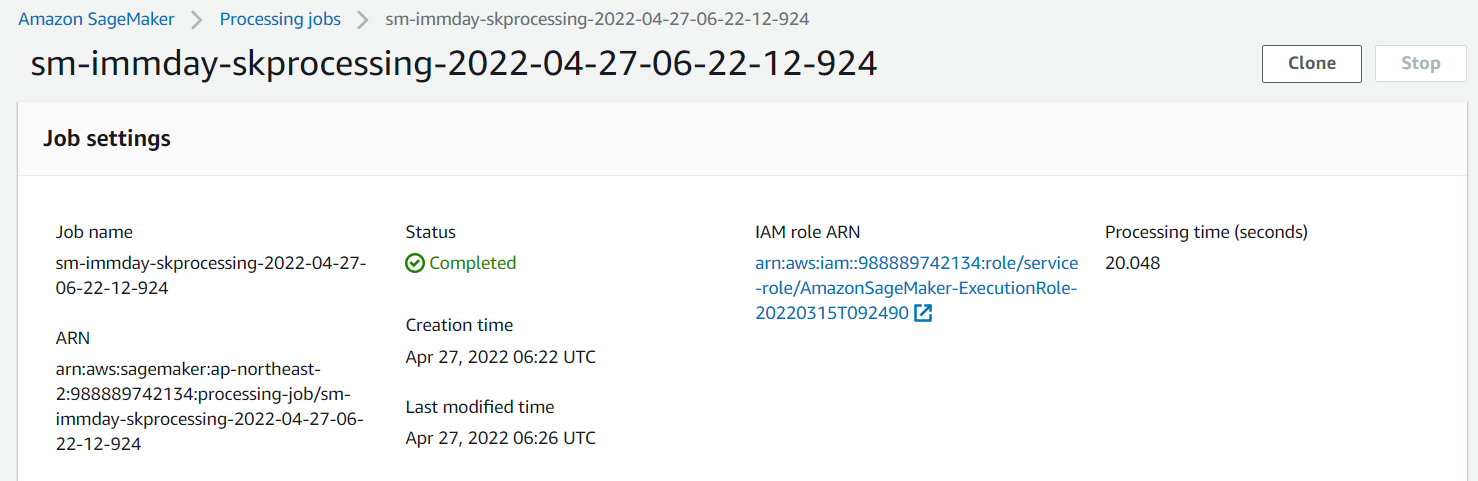

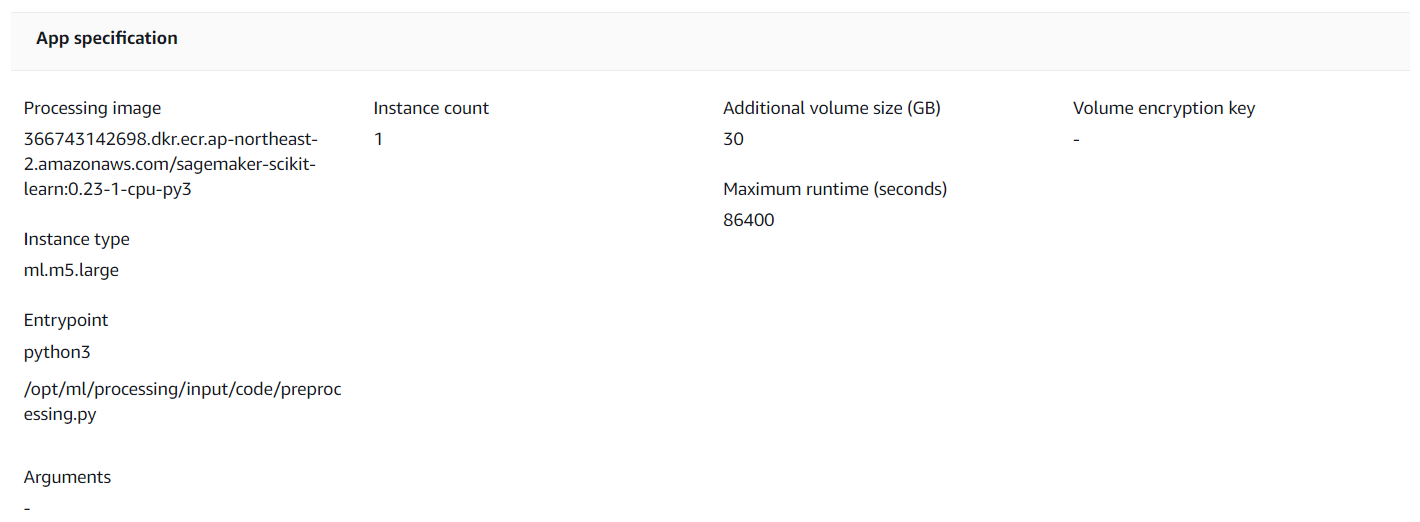

In [26]:
!aws s3 ls $train_path/

2022-04-27 06:26:36    3545009 train.csv


In [27]:
!aws s3 ls $validation_path/

2022-04-27 06:26:36    1012968 validation.csv


In [28]:
!aws s3 ls $test_path/

2022-04-27 06:26:37     498229 test_x.csv
2022-04-27 06:26:37       8238 test_y.csv


---

## Train, Tune and Deploy

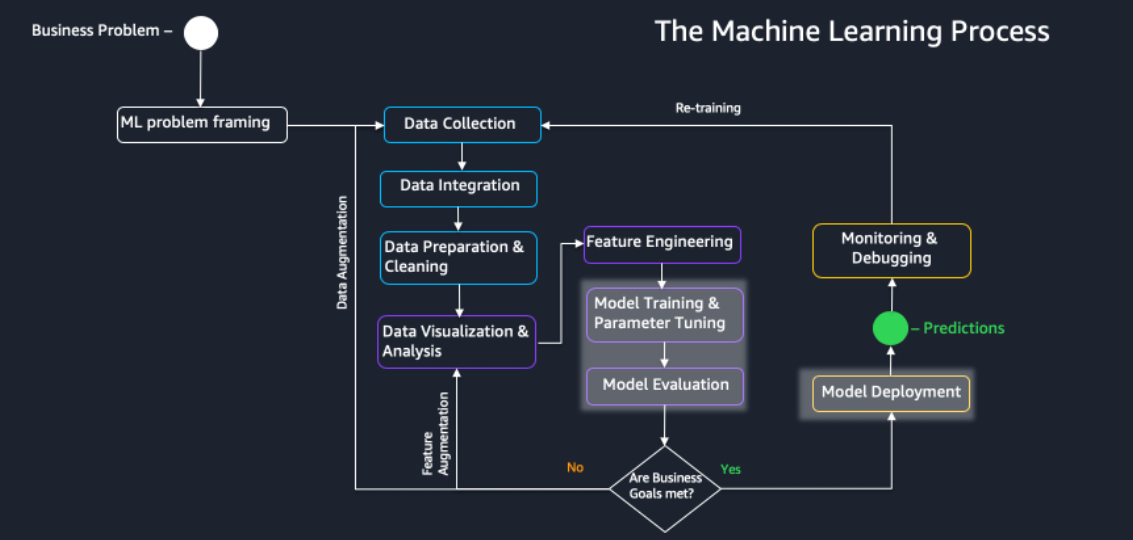

1. Amazon SageMaker XGBoost Model 구현을 위한 ECR Container 위치 지정

In [32]:
container = sagemaker.image_uris.retrieve(
    region=boto3.Session().region_name,
    framework="xgboost",
    version='latest'
)

print('XGBoost Container Image Uri: ', container)

XGBoost Container Image Uri:  306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:latest


2. Content Type을 CSV Format으로 지정

In [36]:
# Train
s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data=train_path.format(bucket, prefix),
    content_type='csv'
)

s3_input_train.config

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/train',
   'S3DataDistributionType': 'FullyReplicated'}},
 'ContentType': 'csv'}

In [37]:
# Validation
s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data=validation_path.format(bucket, prefix),
    content_type='csv'
)

s3_input_validation.config

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/validation',
   'S3DataDistributionType': 'FullyReplicated'}},
 'ContentType': 'csv'}

3. Training parameters 지정
- The xgboost algorithm container
- IAM role to use
- Training instance type and count
- S3 location for output data
- Algorithm hyperparameters

In [38]:
session = sagemaker.Session()

In [39]:
xgb_estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=session
)

In [41]:
xgb_estimator.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    silent=0,
    objective='binary:logistic',
    num_round=100
)

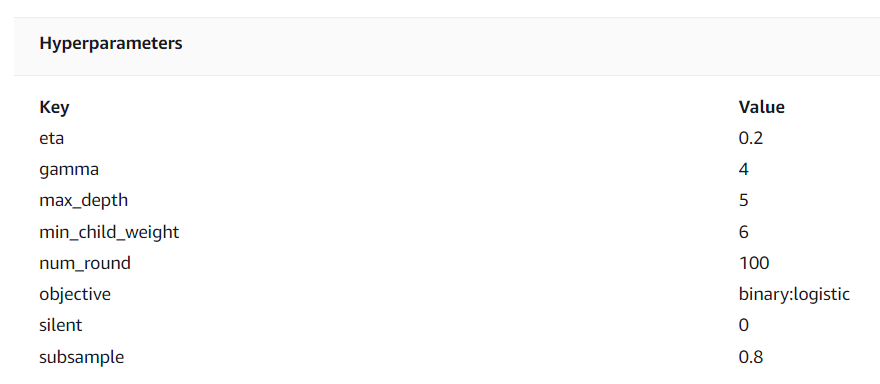

4. XGBoost Model Training 시작

In [42]:
xgb_estimator.fit(
    {
        'train': s3_input_train,
        'validation': s3_input_validation
    }
)

2022-04-27 08:06:29 Starting - Starting the training job...ProfilerReport-1651046788: InProgress
...
2022-04-27 08:07:19 Starting - Preparing the instances for training......
2022-04-27 08:08:20 Downloading - Downloading input data...
2022-04-27 08:08:59 Training - Downloading the training image........Arguments: train
[2022-04-27:08:10:06:INFO] Running standalone xgboost training.
[2022-04-27:08:10:06:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8506.25mb
[2022-04-27:08:10:06:INFO] Determined delimiter of CSV input is ','
[08:10:06] S3DistributionType set as FullyReplicated
[08:10:06] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2022-04-27:08:10:06:INFO] Determined delimiter of CSV input is ','
[08:10:06] S3DistributionType set as FullyReplicated
[08:10:06] 8238x59 matrix with 486042 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,


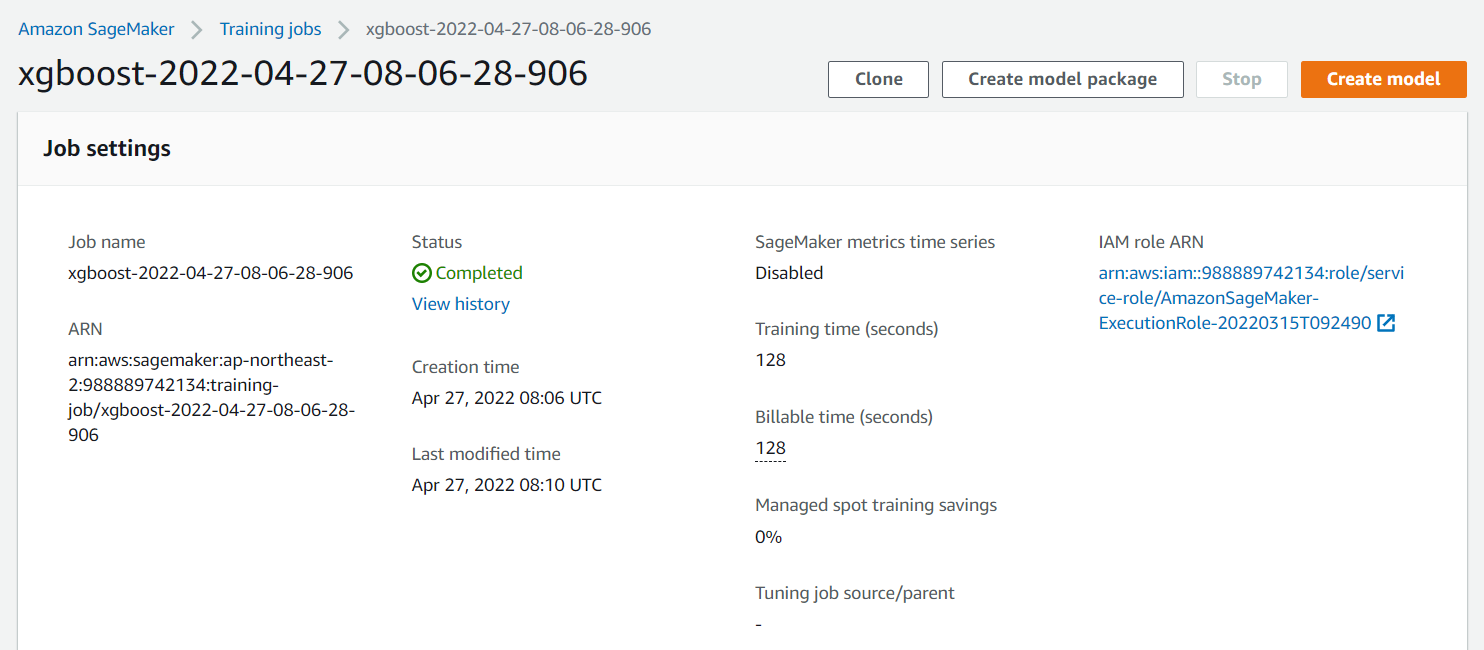

5. Real-time Inference 결과를 얻기 위한 모델 hosting

In [43]:
xgb_predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge'
)

------!

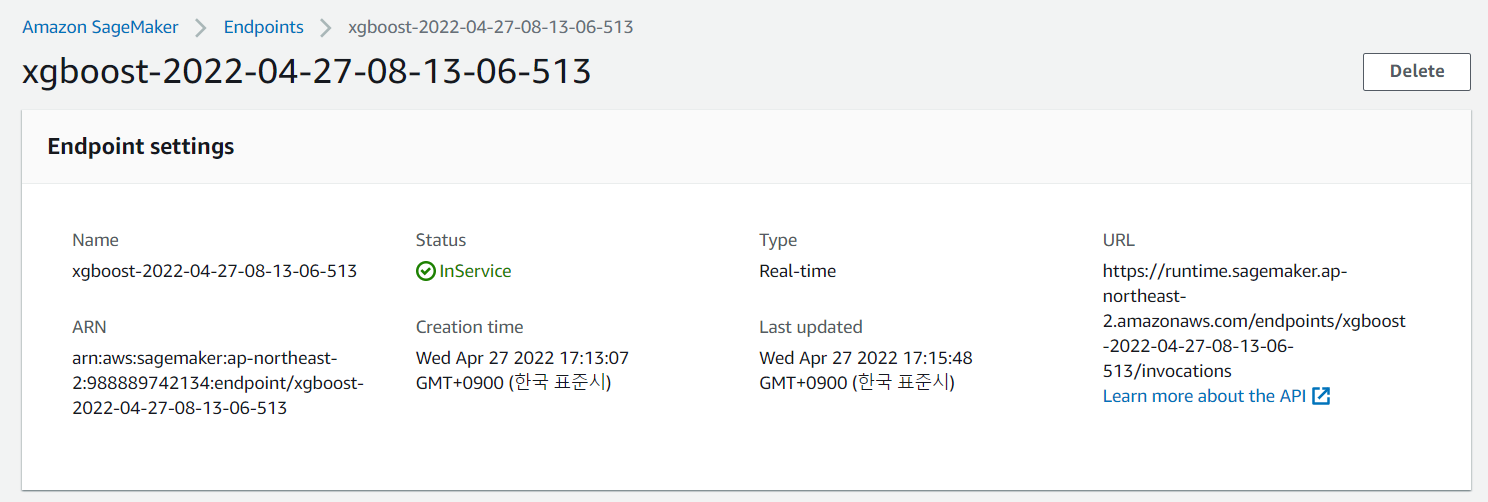

6. Serialize CSV string format

현재 데이터는 노트북 인스턴스 메모리에 NumPy Array로 저장되어 있기 때문에, 이를 HTTP POST 요청으로 전송하기 위해서 CSV 문자열(string)로 Serialize한 다음, 결과 CSV를 decoding 해야 함

In [45]:
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

Steps

1. Loop over our test dataset
2. Split it into mini-batches of rows
3. Convert those mini-batches to CSV string payloads
4. Retrieve mini-batch predictions by invoking the XGBoost endpoint
5. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [46]:
print("test path: ", test_path )

test path:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/test


In [51]:
!aws s3 cp $test_path/test_x.csv ./tmp/test_x.csv
!aws s3 cp $test_path/test_y.csv ./tmp/test_y.csv

download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/test/test_x.csv to tmp/test_x.csv
download: s3://sagemaker-ap-northeast-2-988889742134/sagemaker/DEMO-xgboost-dm/test/test_y.csv to tmp/test_y.csv


In [52]:
!aws s3 ls $test_path/

2022-04-27 06:26:37     498229 test_x.csv
2022-04-27 06:26:37       8238 test_y.csv


In [54]:
test_x = pd.read_csv('./tmp/test_x.csv', names=[f'{i}' for i in range(59)])

In [55]:
test_x.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58
0,53,3,999,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,32,1,999,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,44,1,999,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,36,3,999,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
4,30,1,999,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [58]:
test_x.shape

(4119, 59)

In [56]:
test_y = pd.read_csv('./tmp/test_y.csv', names=['y'])

In [57]:
test_y.head()

,y
0,0
1,0
2,0
3,0
4,0


In [59]:
test_y.shape

(4119, 1)

In [60]:
def predict(data, predictor, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join(
            [predictions, predictor.predict(array).decode('utf-8')]
        )
    return np.fromstring(predictions[1:], sep=',')

In [61]:
predictions = predict(
    test_x.drop(test_x.columns[0], axis=1).to_numpy(),
    xgb_predictor
)

7. Actual 값과 Prediction 값을 비교하는 빈도표 생성 (Pandas Crosstab)

In [62]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions),
    rownames=['actuals'],
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3633,2
1,474,10


8. Clean-up origin xgboost predictor endpoint

In [70]:
xgb_predictor.delete_endpoint(
    delete_endpoint_config=True
)

9. Automatic model Tuning

Amazon SageMaker 자동 모델 튜닝은 사용자가 지정한 하이퍼 파라미터의 알고리즘 범위를 사용하여 데이터 세트에서 많은 교육 작업을 실행하여 최적의 모델 버전을 찾음
-> _**Hyperparameter tuning**_

그 후, 선택한 메트릭에 의해 측정되는 최상의 성능을 발휘하는 모델을 만드는 Hyperparameter 값을 선택

목표: XGBoost 알고리즘 모델을 교육하여, 알고리즘의 곡선(auc) 메트릭 아래의 영역을 최대화 하는 것

- eta: Step size shrinkage used in updates to prevent overfitting. After each boosting step, you can directly get the weights of new features. The eta parameter actually shrinks the feature weights to make the boosting process more conservative.

- min_child_weight: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process gives up further partitioning. In linear regression models, this simply corresponds to a minimum number of instances needed in each node. The larger the algorithm, the more conservative it is.

- alpha: L1 regularization term on weights. Increasing this value makes models more conservative.

- max_depth: Maximum depth of a tree. Increasing this value makes the model more complex and likely to be overfitted.

In [63]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner


hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}

In [64]:
objective_metric_name = 'validation:auc'

In [66]:
tuner = HyperparameterTuner(xgb_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

In [67]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

.......................................................................................................................................................................................................................................................................................................................................................................!


In [68]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [69]:
tuner.best_training_job()

'xgboost-220427-0909-009-e65be1e2'

10. Real-time Inference 결과를 얻기 위한 tuner 모델 hosting

In [71]:
tuner_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge'
)


2022-04-27 09:23:19 Starting - Preparing the instances for training
2022-04-27 09:23:19 Downloading - Downloading input data
2022-04-27 09:23:19 Training - Training image download completed. Training in progress.
2022-04-27 09:23:19 Uploading - Uploading generated training model
2022-04-27 09:23:19 Completed - Training job completed
------!

In [72]:
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [74]:
predictions = predict(
    test_x.to_numpy(),
    tuner_predictor
)

11. Actual 값과 Prediction 값을 비교하는 빈도표 생성 (Pandas Crosstab) - tuner model

In [75]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions),
    rownames=['actuals'],
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3591,44
1,378,106


12. Clean-up origin xgboost tuner predictor endpoint

In [76]:
tuner_predictor.delete_endpoint(
    delete_endpoint_config=True
)